In [1]:
using ModelingToolkit, OrdinaryDiffEq, CairoMakie

In [2]:
@parameters t r₁ Kp₁ r₂ Kp₂ m21 #human population dynamics
@parameters δ₁ δ₂ σ₁ σ₂ s₁ s₂ Cₘ₁ Cₘ₂ a₁ a₂ #economic dynamics
@parameters re₁ re₂ eb u α α₁ α₂ G₀ G₁ Tg η #earth system and climate 


#state variables

@variables P₁(t) P₂(t) K₁(t) K₂(t) G(t) e₁(t) e₂(t) z(t)


θ(x) = (max(0,x))^5/(0.0001^5 + (max(0,x))^5)
@register θ(x)


ϕ(x) = x*θ(x)
@register ϕ(x)


Yᵢ(a,α,K,P) = a*((ϕ(K))^α)*(P^(1-α))
@register Yᵢ(a,α,K,P)

Yᵢ₁ = Yᵢ(a₁,α₁,K₁,P₁)
Yᵢ₂ = Yᵢ(a₂,α₂,K₂,P₂)

Y(P,Y) = P + ϕ(Y-P)
@register Y(P,K)

Y₁ = Y(P₁,Yᵢ₁)
Y₂ = Y(P₂,Yᵢ₂)

er₁ = θ(P₁-Yᵢ₁)*eb + θ(Yᵢ₁-P₁)*e₁
er₂ = θ(P₂-Yᵢ₂)*eb + θ(Yᵢ₂-P₂)*e₂

Yd₁ = ϕ(Y₁ - P₁*Cₘ₁)
Yd₂ = ϕ(Y₂ - P₂*Cₘ₂)

D = Differential(t)

eqs = [
    D(P₁) ~ r₁*P₁*(1 - P₁/Kp₁)+m21*P₂, #human population dynamics 
    D(P₂) ~ r₂*P₂*(1 - P₂/Kp₂)-m21*P₂, # standard logistic.
    D(K₁) ~ s₁*Yd₁ - δ₁*K₁ - σ₁*exp(G-G₁)*K₁, #change in capital stock = 
    D(K₂) ~ s₂*Yd₂ - δ₂*K₂ - σ₂*exp(G-G₁)*K₂, # savings-depreciation-damages
    D(G)  ~ er₁*Y₁ + er₂*Y₂ - u*(G-2.8) + α*θ(G-G₀), # global externality.
    D(z)  ~ η*θ(G-Tg)*(1-z), #initiate decarbonization - Tg
    D(e₁) ~ -z*re₁*e₁, # decarbonization in region 1
    D(e₂) ~ -z*re₂*e₂ # decarbonization in region 2
    ]

@named sys = ODESystem(eqs);

In [3]:
e_vary = [0.0001,0.0004,0.005]
tg_vary=[50,50,500]
re_vary = [0.0,0.1,0.5]
m21_vary = [0,0.001,0.01]
##G₀=20 G₁=5 Tg=50 eb=0.00004
#re₁=>0.1, re₂=>0.1, eb=>0.00004, Tg=>50, #carbon intensities

l = length(e_vary)
years = LinRange(1900,2501,601)
G_vary = zeros(l,601);
P1_vary = zeros(l,601);
P2_vary = zeros(l,601);
K1_vary = zeros(l,601);
K2_vary = zeros(l,601);
O1_vary = zeros(l,601);
O2_vary = zeros(l,601);
OT_vary = zeros(l,601);
PCO1_vary = zeros(l,601);
PCO2_vary = zeros(l,601);

G_vary_m1 = zeros(l,601);
P1_vary_m1 = zeros(l,601);
P2_vary_m1 = zeros(l,601);
K1_vary_m1 = zeros(l,601);
K2_vary_m1 = zeros(l,601);
O1_vary_m1 = zeros(l,601);
O2_vary_m1 = zeros(l,601);
OT_vary_m1 = zeros(l,601);
PCO1_vary_m1 = zeros(l,601);
PCO2_vary_m1 = zeros(l,601);

G_vary_m2 = zeros(l,601);
P1_vary_m2 = zeros(l,601);
P2_vary_m2 = zeros(l,601);
K1_vary_m2 = zeros(l,601);
K2_vary_m2 = zeros(l,601);
O1_vary_m2 = zeros(l,601);
O2_vary_m2 = zeros(l,601);
OT_vary_m2 = zeros(l,601);
PCO1_vary_m2 = zeros(l,601);
PCO2_vary_m2 = zeros(l,601);


In [4]:
## ZERO MIGRATION _ SOLID LINE 
for i in 1:3

# assign values to parameters
p=[r₁=>0.038, Kp₁=>1.5, #populatin growth, carrying capacity
    r₂=>0.042, Kp₂=>9.7, #populatin growth, carrying capacity
    α₁=>0.5, α₂=>0.5, #capital factor productivity
    a₁=>2.7, a₂=>1.7, #total factor productivity
    δ₁=>0.05, δ₂=>0.05, #capital entropic decay rates  
    s₁=>0.25, s₂=>0.21, #savings rates (of disposable income)
    Cₘ₁=>0.7, Cₘ₂=>0.7, #minimum subsistence consumption
    σ₁=>0.03, σ₂=>0.03, #climate damages on infrastructure
    re₁=>0.01, re₂=>0.01, eb=>0.00004, Tg=>20, #carbon intensities
    η=>1, #rate at which decarbonization is initiated
    u=>0.0025, α=>0.1, #earth system carbon uptake and release
    G₁=>5, G₀=>20,#g0_vary[i] #G1=damage threshold, G₀ = climate threshold 
    m21=> 0
]

#set initial conditions

u0=[P₁=>0.24,P₂=>0.24,K₁=>0,K₂=>0,
    G=>2.8,e₁=>e_vary[i],e₂=>e_vary[i],z=>0]

#set time span for integrating the system

tspan=(0.0,600.0); #time span in years.

prob=ODEProblem(sys,u0,tspan,p);

sol=solve(prob,Tsit5(),saveat=1.0);  


P1_vary[i,:] = sol[1,:];
P2_vary[i,:] = sol[2,:];
K1_vary[i,:]= sol[3,:];
K2_vary[i,:] = sol[4,:];
G_vary[i,:] = sol[5,:];
#em₁ = sol[7,:];
#em₂ = sol[8,:];
t = sol.t;

#G_vary[i,:] = g

O(a,α,K,P) = max.(P, a*(K.^α).*(P.^(1-α)));

O1_vary[i,:] = O(p[7][2],p[5][2],K1_vary[i,:],P1_vary[i,:]);
O2_vary[i,:] = O(p[8][2],p[6][2],K2_vary[i,:],P2_vary[i,:]);

OT_vary[i,:] = O1_vary[i,:] + O2_vary[i,:];

# using PCO for per capita output....

PCO1_vary[i,:] = O1_vary[i,:]./P1_vary[i,:];   
PCO2_vary[i,:] = O2_vary[i,:]./P2_vary[i,:];

end

In [5]:
## Small migration rate_ DOT LINE m21 = 0.001
for i in 1:3

    # assign values to parameters
    p=[r₁=>0.038, Kp₁=>1.5, #populatin growth, carrying capacity
        r₂=>0.042, Kp₂=>9.7, #populatin growth, carrying capacity
        α₁=>0.5, α₂=>0.5, #capital factor productivity
        a₁=>2.7, a₂=>1.7, #total factor productivity
        δ₁=>0.05, δ₂=>0.05, #capital entropic decay rates  
        s₁=>0.25, s₂=>0.21, #savings rates (of disposable income)
        Cₘ₁=>0.7, Cₘ₂=>0.7, #minimum subsistence consumption
        σ₁=>0.03, σ₂=>0.03, #climate damages on infrastructure
        re₁=>0.01, re₂=>0.01, eb=>0.00004, Tg=>20, #carbon intensities
        η=>1, #rate at which decarbonization is initiated
        u=>0.0025, α=>0.1, #earth system carbon uptake and release
        G₁=>5, G₀=>20,#g0_vary[i] #G1=damage threshold, G₀ = climate threshold 
        m21 => 0.001
    ]
    
    #set initial conditions
    
    u0=[P₁=>0.24,P₂=>0.24,K₁=>0,K₂=>0,
        G=>2.8,e₁=>e_vary[i],e₂=>e_vary[i],z=>0]
    
    #set time span for integrating the system
    
    tspan=(0.0,600.0); #time span in years.
    
    prob=ODEProblem(sys,u0,tspan,p);
    
    sol=solve(prob,Tsit5(),saveat=1.0);  
    
    
    P1_vary_m1[i,:] = sol[1,:];
    P2_vary_m1[i,:] = sol[2,:];
    K1_vary_m1[i,:]= sol[3,:];
    K2_vary_m1[i,:] = sol[4,:];
    G_vary_m1[i,:] = sol[5,:];
    #em₁ = sol[7,:];
    #em₂ = sol[8,:];
    t = sol.t;
    
    #G_vary[i,:] = g
    
    O(a,α,K,P) = max.(P, a*(K.^α).*(P.^(1-α)));
    
    O1_vary_m1[i,:] = O(p[7][2],p[5][2],K1_vary_m1[i,:],P1_vary_m1[i,:]);
    O2_vary_m1[i,:] = O(p[8][2],p[6][2],K2_vary_m1[i,:],P2_vary_m1[i,:]);
    
    OT_vary_m1[i,:] = O1_vary_m1[i,:] + O2_vary_m1[i,:];
    
    # using PCO for per capita output....
    
    PCO1_vary_m1[i,:] = O1_vary_m1[i,:]./P1_vary_m1[i,:];   
    PCO2_vary_m1[i,:] = O2_vary_m1[i,:]./P2_vary_m1[i,:];
    
    end

In [6]:
## big migration rate_ dot dash LINE 0.01
for i in 1:3

    # assign values to parameters
    p=[r₁=>0.038, Kp₁=>1.5, #populatin growth, carrying capacity
        r₂=>0.042, Kp₂=>9.7, #populatin growth, carrying capacity
        α₁=>0.5, α₂=>0.5, #capital factor productivity
        a₁=>2.7, a₂=>1.7, #total factor productivity
        δ₁=>0.05, δ₂=>0.05, #capital entropic decay rates  
        s₁=>0.25, s₂=>0.21, #savings rates (of disposable income)
        Cₘ₁=>0.7, Cₘ₂=>0.7, #minimum subsistence consumption
        σ₁=>0.03, σ₂=>0.03, #climate damages on infrastructure
        re₁=>0.01, re₂=>0.01, eb=>0.00004, Tg=>20, #carbon intensities
        η=>1, #rate at which decarbonization is initiated
        u=>0.0025, α=>0.1, #earth system carbon uptake and release
        G₁=>5, G₀=>20,#g0_vary[i] #G1=damage threshold, G₀ = climate threshold 
        m21 => 0.01
    ]
    
    #set initial conditions
    
    u0=[P₁=>0.24,P₂=>0.24,K₁=>0,K₂=>0,
        G=>2.8,e₁=>e_vary[i],e₂=>e_vary[i],z=>0]
    
    #set time span for integrating the system
    
    tspan=(0.0,600.0); #time span in years.
    
    prob=ODEProblem(sys,u0,tspan,p);
    
    sol=solve(prob,Tsit5(),saveat=1.0);  
    
    
    P1_vary_m2[i,:] = sol[1,:];
    P2_vary_m2[i,:] = sol[2,:];
    K1_vary_m2[i,:]= sol[3,:];
    K2_vary_m2[i,:] = sol[4,:];
    G_vary_m2[i,:] = sol[5,:];
    #em₁ = sol[7,:];
    #em₂ = sol[8,:];
    t = sol.t;
    
    #G_vary[i,:] = g
    
    O(a,α,K,P) = max.(P, a*(K.^α).*(P.^(1-α)));
    
    O1_vary_m2[i,:] = O(p[7][2],p[5][2],K1_vary_m2[i,:],P1_vary_m2[i,:]);
    O2_vary_m2[i,:] = O(p[8][2],p[6][2],K2_vary_m2[i,:],P2_vary_m2[i,:]);
    
    OT_vary_m2[i,:] = O1_vary_m2[i,:] + O2_vary_m2[i,:];
    
    # using PCO for per capita output....
    
    PCO1_vary_m2[i,:] = O1_vary_m2[i,:]./P1_vary_m2[i,:];   
    PCO2_vary_m2[i,:] = O2_vary_m2[i,:]./P2_vary_m2[i,:];
    
    end

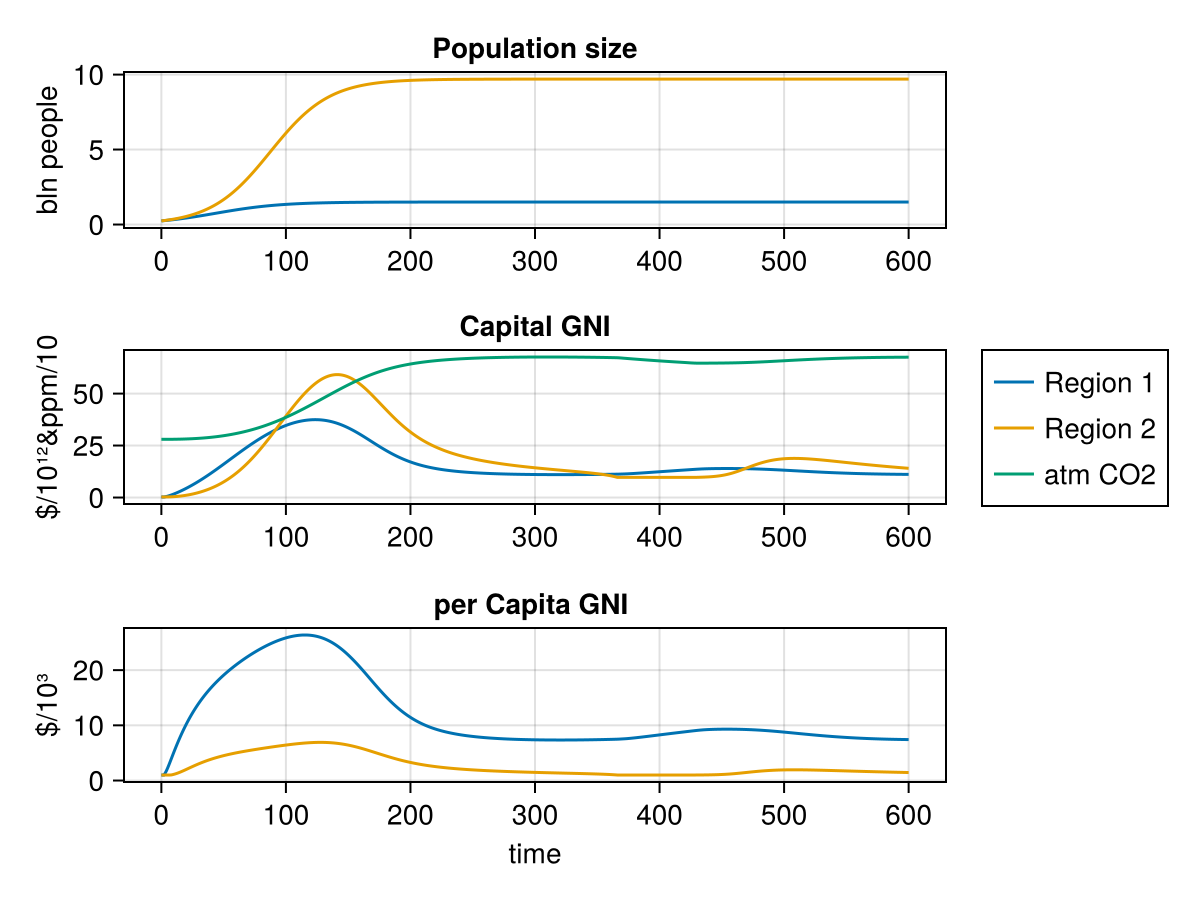

In [7]:
f1=Figure()

a=Axis(f1[1,1], title = "Population size", ylabel = "bln people")
b=Axis(f1[2,1],title = "Capital GNI", ylabel = "\$/10¹²&ppm/10")
c=Axis(f1[3,1], title = "per Capita GNI ", ylabel = "\$/10³" ,xlabel = "time")

#define the plots (the variables to plot) to show

h9=lines!(a,t,P1_vary[2,:])
h10=lines!(a,t,P2_vary[2,:])

h4=lines!(b,t,O1_vary[2,:])
h5=lines!(b,t,O2_vary[2,:])
h6=lines!(b,t,10*G_vary[2,:])

lines!(c,t,O1_vary[2,:]./P1_vary[2,:])
lines!(c,t,O2_vary[2,:]./P2_vary[2,:])

#set the legend
Legend(f1[1:3,2],[h4,h5,h6],["Region 1","Region 2","atm CO2"])

f1

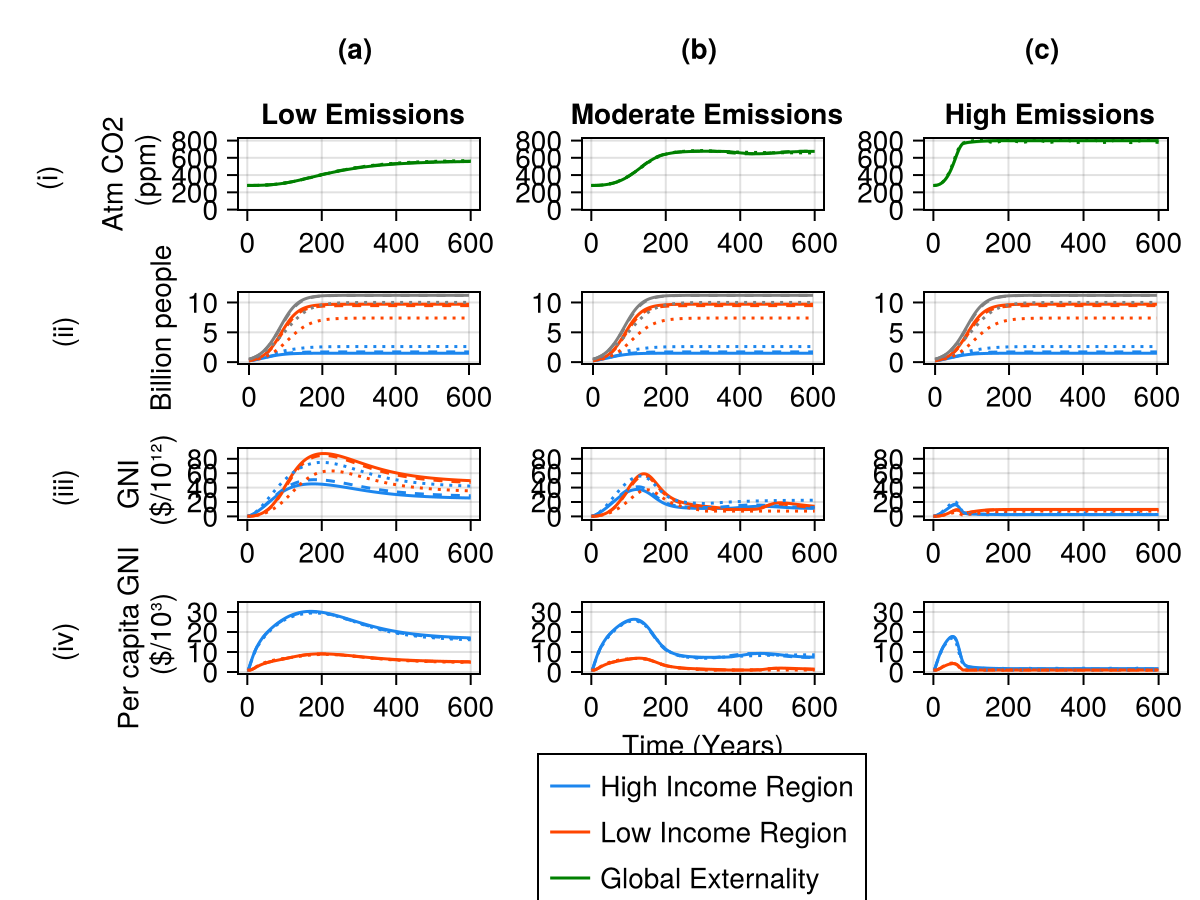

In [15]:
f2=Figure(backgroundcolor = :white,resolution=(750,500))

a=Axis(f2[2,1], ylabel = "(ii) \n \n \n Billion people ",xticks=0:200:length(t))
b=Axis(f2[3 ,1], ylabel = "(iii) \n \n GNI \n (\$/10¹²)",xticks=0:200:length(t),limits=(-25,625,-5,95),yticks=0:20:80)
bb = Axis(f2[1,1], ylabel = "(i) \n \n Atm CO2 \n (ppm)" ,title = "(a) \n \n Low Emissions",xticks=0:200:length(t),limits=(-25,625,-5,830),yticks=0:200:800)
c=Axis(f2[4,1], ylabel = "(iv) \n \n Per capita GNI \n (\$/10³)",xticks=0:200:length(t),limits=(-25,625,-1,35),yticks=0:10:30)
d=Axis(f2[2,2],xticks=0:200:length(t))
e=Axis(f2[3,2],xticks=0:200:length(t),limits=(-25,625,-5,95),yticks=0:20:80)
ee = Axis(f2[1,2], title = "(b) \n \n Moderate Emissions",xticks=0:200:length(t),limits=(-25,625,-5,830),yticks=0:200:800)
f=Axis(f2[4,2],xlabel = "Time (Years)",xticks=0:200:length(t),limits=(-25,625,-1,35),yticks=0:10:30)
gg=Axis(f2[2,3], xticks=0:200:length(t))
h=Axis(f2[3,3],xticks=0:200:length(t),limits=(-25,625,-5,95),yticks=0:20:80)
hi = Axis(f2[1,3],title = "(c) \n \n High Emissions",xticks=0:200:length(t),limits=(-25,625,-5,830),yticks=0:200:800)
ii=Axis(f2[4,3], xticks=0:200:length(t),limits=(-25,625,-1,35),yticks=0:10:30)

#define the plots (the variables to plot) to show
###population: a,d,gg
h9=lines!(a,t,P1_vary[1,:],color = :dodgerblue2)
h10=lines!(a,t,P2_vary[1,:],color = :orangered)
h11=lines!(a,t,P1_vary[1,:]+P2_vary[1,:],color = :gray)
lines!(d,t,P1_vary[2,:],color = :dodgerblue2)
lines!(d,t,P2_vary[2,:],color = :orangered)
lines!(d,t,P1_vary[2,:]+P2_vary[2,:],color = :gray)
lines!(gg,t,P1_vary[3,:],color = :dodgerblue2)
lines!(gg,t,P2_vary[3,:],color = :orangered)
lines!(gg,t,P1_vary[3,:]+P2_vary[3,:],color = :gray)

lines!(a,t,P1_vary_m1[1,:],linestyle=:dash,color = :dodgerblue2)
lines!(a,t,P2_vary_m1[1,:],linestyle=:dash,color = :orangered)
lines!(a,t,P1_vary_m1[1,:]+P2_vary_m1[1,:], linestyle=:dash,color = :gray)
lines!(d,t,P1_vary_m1[2,:],linestyle=:dash,color = :dodgerblue2)
lines!(d,t,P2_vary_m1[2,:],linestyle=:dash,color = :orangered)
lines!(d,t,P1_vary_m1[2,:]+P2_vary_m1[2,:], linestyle=:dash,color = :gray)
lines!(gg,t,P1_vary_m1[3,:],linestyle=:dash,color = :dodgerblue2)
lines!(gg,t,P2_vary_m1[3,:],linestyle=:dash,color = :orangered)
lines!(gg,t,P1_vary_m1[3,:]+P2_vary_m1[3,:], linestyle=:dash,color = :gray)

lines!(a,t,P1_vary_m2[1,:],color = :dodgerblue2,linestyle=:dot)
lines!(a,t,P2_vary_m2[1,:],linestyle=:dot,color = :orangered)
lines!(a,t,P1_vary_m2[1,:]+P2_vary_m2[1,:], linestyle=:dot,color = :gray)
lines!(d,t,P1_vary_m2[2,:],color = :dodgerblue2,linestyle=:dot)
lines!(d,t,P2_vary_m2[2,:],linestyle=:dot,color = :orangered)
lines!(d,t,P1_vary_m2[2,:]+P2_vary_m2[2,:], linestyle=:dot,color = :gray)
lines!(gg,t,P1_vary_m2[3,:],color = :dodgerblue2,linestyle=:dot)
lines!(gg,t,P2_vary_m2[3,:],linestyle=:dot,color = :orangered)
lines!(gg,t,P1_vary_m2[3,:]+P2_vary_m2[3,:], linestyle=:dot,color = :gray)


### capital: b,e,h
h4=lines!(b,t,O1_vary[1,:],color = :dodgerblue2)
h5=lines!(b,t,O2_vary[1,:],color = :orangered)
h6=lines!(bb,t,G_vary[1,:]*100,color = :green)
lines!(e,t,O1_vary[2,:],color = :dodgerblue2)
lines!(e,t,O2_vary[2,:],color = :orangered)
lines!(ee,t,100*G_vary[2,:],color = :green)
lines!(h,t,O1_vary[3,:],color = :dodgerblue2)
lines!(h,t,O2_vary[3,:],color = :orangered)
lines!(hi,t,100*G_vary[3,:],color = :lightgreen)

lines!(b,t,O1_vary_m1[1,:],linestyle=:dash,color = :dodgerblue2)
lines!(b,t,O2_vary_m1[1,:],linestyle=:dash,color = :orangered)
lines!(bb,t,G_vary_m1[1,:]*100,color = :green,linestyle=:dash)
lines!(e,t,O1_vary_m1[2,:],linestyle=:dash,color = :dodgerblue2)
lines!(e,t,O2_vary_m1[2,:],linestyle=:dash,color = :orangered)
lines!(ee,t,100*G_vary_m1[2,:],color = :green,linestyle=:dash)
lines!(h,t,O1_vary_m1[3,:],linestyle=:dash,color = :dodgerblue2)
lines!(h,t,O2_vary_m1[3,:],linestyle=:dash,color = :orangered)
lines!(hi,t,100*G_vary_m1[3,:],color = :green)

lines!(b,t,O1_vary_m2[1,:],linestyle=:dot,color = :dodgerblue2)
lines!(b,t,O2_vary_m2[1,:],linestyle=:dot,color = :orangered)
lines!(bb,t,G_vary_m2[1,:]*100,linestyle=:dot,color = :green)
lines!(e,t,O1_vary_m2[2,:],linestyle=:dot,color = :dodgerblue2)
lines!(e,t,O2_vary_m2[2,:],linestyle=:dot,color = :orangered)
lines!(ee,t,100*G_vary_m2[2,:],linestyle=:dot,color = :green)
lines!(h,t,O1_vary_m2[3,:],linestyle=:dot,color = :dodgerblue2)
lines!(h,t,O2_vary_m2[3,:],linestyle=:dot,color = :orangered)
lines!(hi,t,100*G_vary_m2[3,:],linestyle=:dot,color = :green)

###per capita capital c,f,ii
h7=lines!(c,t,O1_vary[1,:]./P1_vary[1,:],color = :dodgerblue2)
h8=lines!(c,t,O2_vary[1,:]./P2_vary[1,:],color = :orangered)
lines!(f,t,O1_vary[2,:]./P1_vary[2,:],color = :dodgerblue2)
lines!(f,t,O2_vary[2,:]./P2_vary[2,:],color = :orangered)
lines!(ii,t,O1_vary[3,:]./P1_vary[3,:],color = :dodgerblue2)
lines!(ii,t,O2_vary[3,:]./P2_vary[3,:],color = :orangered)

lines!(c,t,O1_vary_m1[1,:]./P1_vary_m1[1,:],linestyle=:dash,color = :dodgerblue2)
lines!(c,t,O2_vary_m1[1,:]./P2_vary_m1[1,:],linestyle=:dash,color = :orangered)
lines!(f,t,O1_vary_m1[2,:]./P1_vary_m1[2,:],linestyle=:dash,color = :dodgerblue2)
lines!(f,t,O2_vary_m1[2,:]./P2_vary_m1[2,:],linestyle=:dash,color = :orangered)
lines!(ii,t,O1_vary_m1[3,:]./P1_vary_m1[3,:],linestyle=:dash,color = :dodgerblue2)
lines!(ii,t,O2_vary_m1[3,:]./P2_vary_m1[3,:],linestyle=:dash,color = :orangered)

lines!(c,t,O1_vary_m2[1,:]./P1_vary_m2[1,:],linestyle=:dot,color = :dodgerblue2)
lines!(c,t,O2_vary_m2[1,:]./P2_vary_m2[1,:],linestyle=:dot,color = :orangered)
lines!(f,t,O1_vary_m2[2,:]./P1_vary_m2[2,:],linestyle=:dot,color = :dodgerblue2)
lines!(f,t,O2_vary_m2[2,:]./P2_vary_m2[2,:],linestyle=:dot,color = :orangered)
lines!(ii,t,O1_vary_m2[3,:]./P1_vary_m2[3,:],linestyle=:dot,color = :dodgerblue2)
lines!(ii,t,O2_vary_m2[3,:]./P2_vary_m2[3,:],linestyle=:dot,color = :orangered)


#set the legend
Legend(f2[5,1:3],[h4,h5,h6],["High Income Region","Low Income Region","Global Externality"])

f2

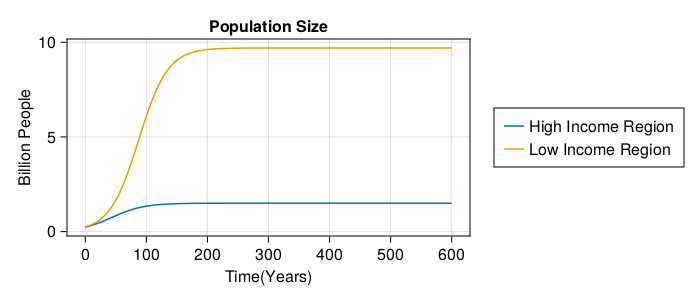

In [17]:
f3 = Figure(backgroundcolor = :white, resolution = (700, 300))
aa = Axis(f3[1,1], title = "Population Size", ylabel = "Billion People", xlabel= "Time(Years)")
h1 = lines!(aa,t,P1_vary[1,:])
h2 = lines!(aa,t,P2_vary[1,:])

Legend(f3[1,2],[h1, h2],["High Income Region" ,"Low Income Region"])
f3 

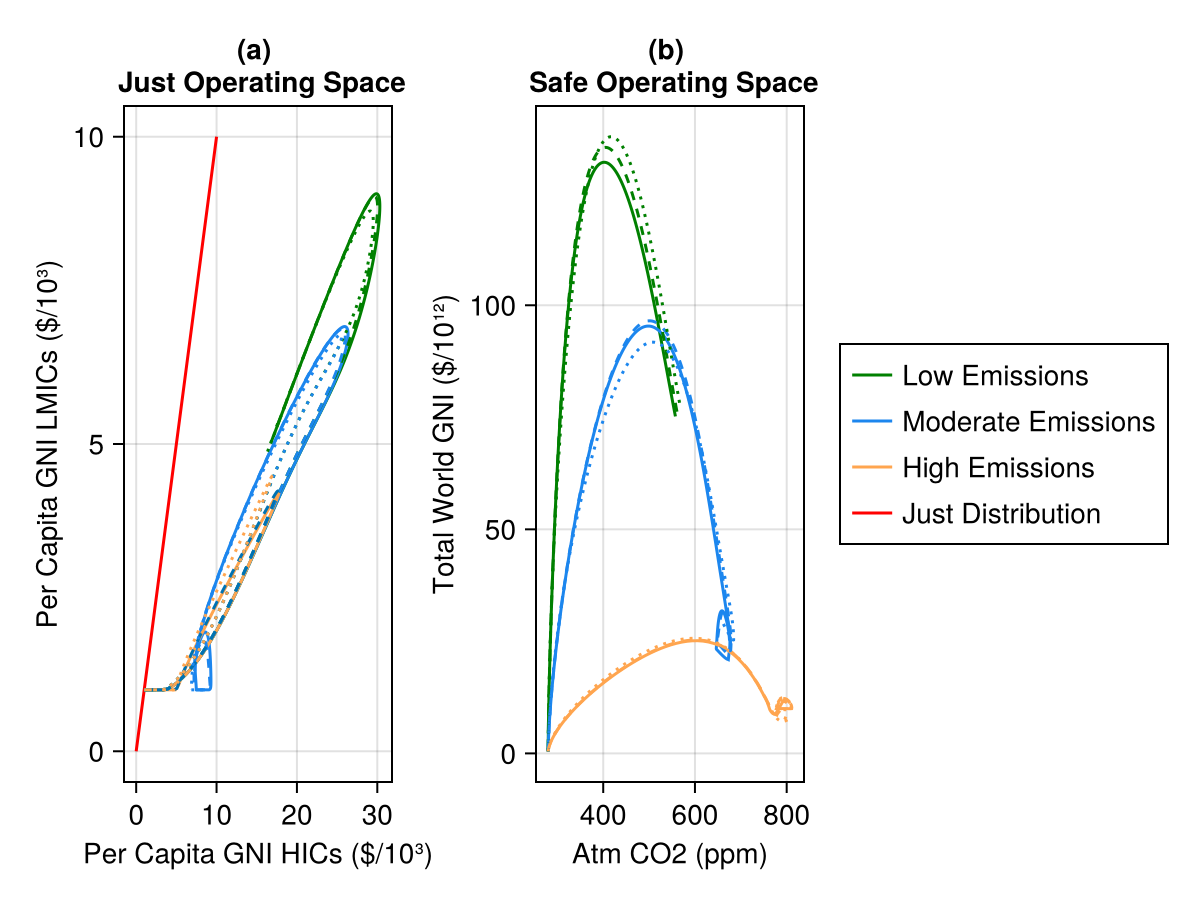

In [8]:
f4 = Figure()
a=Axis(f4[1,1],xlabel = "Per Capita GNI HICs (\$/10³)", ylabel = "Per Capita GNI LMICs (\$/10³)",title = "(a) \n Just Operating Space")
b=Axis(f4[1,2], ylabel = "Total World GNI (\$/10¹²)", xlabel = "Atm CO2 (ppm)", title = "(b) \n Safe Operating Space");
#c=Axis(f4[1,3], ylabel = "Per Capita GNI (\$/10¹²)", xlabel = "Time (Years)");
x = LinRange(0,10,10)
y = LinRange(0,10,10)
eq = lines!(a,x,y,color=:red)

l=lines!(a,PCO1_vary[1,:],PCO2_vary[1,:],color = :green);
m=lines!(a,PCO1_vary[2,:],PCO2_vary[2,:],color = :dodgerblue2);
h=lines!(a,PCO1_vary[3,:],PCO2_vary[3,:],color=:tan1);
ll=lines!(b,100*G_vary[1,:],OT_vary[1,:],color = :green)
mm=lines!(b,100*G_vary[2,:],OT_vary[2,:],color = :dodgerblue2)
he=lines!(b,100*G_vary[3,:],OT_vary[3,:],color=:tan1)

lines!(a,PCO1_vary_m1[1,:],PCO2_vary_m1[1,:],linestyle=:dash,color = :green);
lines!(a,PCO1_vary_m1[2,:],PCO2_vary_m1[2,:],linestyle=:dash,color = :dodgerblue2);
lines!(a,PCO1_vary_m1[3,:],PCO2_vary_m1[3,:],linestyle=:dash);
lines!(b,100*G_vary_m1[1,:],OT_vary_m1[1,:],linestyle=:dash,color = :green)
lines!(b,100*G_vary_m1[2,:],OT_vary_m1[2,:],linestyle=:dash,color = :dodgerblue2)
lines!(b,100*G_vary_m1[3,:],OT_vary_m1[3,:],linestyle=:dash,color=:tan1)

lines!(a,PCO1_vary_m2[1,:],PCO2_vary_m2[1,:],linestyle=:dot,color = :green);
lines!(a,PCO1_vary_m2[2,:],PCO2_vary_m2[2,:],linestyle=:dot,color = :dodgerblue2);
lines!(a,PCO1_vary_m2[3,:],PCO2_vary_m2[3,:],linestyle=:dot,color=:tan1);
lines!(b,100*G_vary_m2[1,:],OT_vary_m2[1,:],linestyle=:dot,color = :green)
lines!(b,100*G_vary_m2[2,:],OT_vary_m2[2,:],linestyle=:dot,color = :dodgerblue2)
lines!(b,100*G_vary_m2[3,:],OT_vary_m2[3,:],linestyle=:dot,color=:tan1)



#set the legend
Legend(f4[1,3],[l,m,h,eq],["Low Emissions","Moderate Emissions","High Emissions","Just Distribution"])


f4


In [9]:
save("SJOS_basline_emission_scenarios.svg",f4)

CairoMakie.Screen{SVG}


In [30]:
# Get the default color palette
palette = :color_palette

# Print the default colors
print(palette)

color_palette

### Second Scenario - Climate Threshold 

In [53]:

l = length()

G_vary = zeros(l,601);
P1_vary = zeros(l,601);
P2_vary = zeros(l,601);
K1_vary = zeros(l,601);
K2_vary = zeros(l,601);
O1_vary = zeros(l,601);
O2_vary = zeros(l,601);
OT_vary = zeros(l,601);
PCO1_vary = zeros(l,601);
PCO2_vary = zeros(l,601);

In [ ]:
for i in 1:3

    # assign values to parameters
    p=[r₁=>0.038, Kp₁=>1.5, #populatin growth, carrying capacity
        r₂=>0.042, Kp₂=>9.7, #populatin growth, carrying capacity
        α₁=>0.5, α₂=>0.5, #capital factor productivity
        a₁=>2.7, a₂=>1.7, #total factor productivity
        δ₁=>0.05, δ₂=>0.05, #capital entropic decay rates  
        s₁=>0.25, s₂=>0.21, #savings rates (of disposable income)
        Cₘ₁=>0.7, Cₘ₂=>0.7, #minimum subsistence consumption
        σ₁=>0.03, σ₂=>0.03, #climate damages on infrastructure
        re₁=>0.1, re₂=>0.1, eb=>0.00004, Tg=>50, #carbon intensities
        η=>1, #rate at which decarbonization is initiated
        u=>0.0025, α=>0.1, #earth system carbon uptake and release
        G₁=>5, G₀=>20 #G1=damage threshold, G₀ = climate threshold 
    ]
    
    
    
    #set initial conditions
    
    u0=[P₁=>0.24,P₂=>0.24,K₁=>0,K₂=>0,
        G=>2.8,e₁=>0.0004,e₂=>0.0004,z=>0]
    
    #set time span for integrating the system
    
    tspan=(0.0,600.0); #time span in years.
    
    prob=ODEProblem(sys,u0,tspan,p);
    
    sol=solve(prob,Tsit5(),saveat=1.0);  
    
    
    P1_vary[i,:] = sol[1,:];
    P2_vary[i,:] = sol[2,:];
    K1_vary[i,:]= sol[3,:];
    K2_vary[i,:] = sol[4,:];
    G_vary[i,:] = sol[5,:];
    #em₁ = sol[7,:];
    #em₂ = sol[8,:];
    t = sol.t;
    
    #G_vary[i,:] = g
    
    O(a,α,K,P) = max.(P, a*(K.^α).*(P.^(1-α)));
    
    O1_vary[i,:] = O(p[7][2],p[5][2],K1_vary[i,:],P1_vary[i,:]);
    O2_vary[i,:] = O(p[8][2],p[6][2],K2_vary[i,:],P2_vary[i,:]);
    
    OT_vary[i,:] = O1_vary[i,:] + O2_vary[i,:];
    
    # using PCO for per capita output....
    
    PCO1_vary[i,:] = O1_vary[i,:]./P1_vary[i,:];   
    PCO2_vary[i,:] = O2_vary[i,:]./P2_vary[i,:];
    
    end

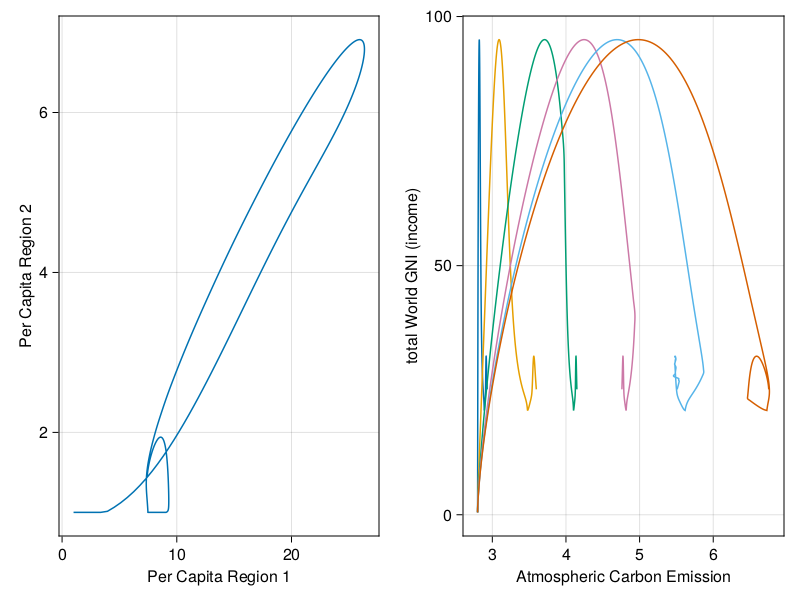

In [91]:
f2=Figure()

d=Axis(f2[1,1],xlabel = "Per Capita Region 1", ylabel = "Per Capita Region 2")
e=Axis(f2[1,2], ylabel = "total World GNI (income)", xlabel = "Atmospheric Carbon Emission");

h21 = lines!(d,PCO₁,PCO₂);
h22 = lines!(e,G_vary[1,:],OT);
h23 = lines!(e,G_vary[2,:],OT);
h24 = lines!(e,G_vary[3,:],OT);
h25 = lines!(e,G_vary[4,:],OT);
h26 = lines!(e,G_vary[5,:],OT);
h27 = lines!(e,G_vary[6,:],OT);

f2


In [63]:
ensembleprob = EnsembleProblem(prob)

EnsembleProblem with problem ODEProblem

In [37]:
sol2 = solve(ensembleprob,Tsit5(),trajectories=5)

EnsembleSolution Solution of length 5 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.Fun